# 1. Introduction
- Brief Overview of the Task
In this task, the goal was to delve into the world of energy storages and energy markets, focusing on the influence of various factors on energy trading with energy storage systems. 
The primary objective was to develop a simplified algorithm capable of estimating the cycle costs required to achieve a specific average daily cycle count for an energy storage system, without breaching the maximum daily number of cycles.

# Theoretical Background
- Electricity Grids and Frequency: Electricity grids operate at a certain frequency, maintained when the supply and demand of electricity are matched. Deviations in this balance could lead to grid instability and power failures.
- Energy Storage Systems: With the increasing incorporation of renewable energies, grid-scale energy storage systems, particularly battery energy storage systems, provide additional flexibility and are optimal for short-term electricity markets.
- Battery Usage and Degradation: The usage of battery storage is measured in cycles, and frequent usage accelerates degradation. The batteries are used to exploit price spreads by buying energy during low-price periods and selling it during high-price periods.
- Cycle Costs: These are associated with one cycle of storage usage and are used to determine the minimum spread required for storage operation to be economically viable.

# Objective
The objective was to develop a Python-based solution to estimate cycle costs, considering factors like efficiency, storage limitations, and price signals, while adhering to the given constraints on average and maximum daily cycles.

In [31]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [32]:
data = pd.read_csv(r"C:\Users\NIDHAL\Desktop\market_prices.csv" , sep=';')
data

timestamp_UTC  price_idm_continuous_qh_vwap_EUR/MWh
0      31.12.2021 23:00                                 85.57
1      31.12.2021 23:15                                 36.80
2      31.12.2021 23:30                                 32.64
3      31.12.2021 23:45                                 32.08
4      01.01.2022 00:00                                 51.71
...                 ...                                   ...
35035  31.12.2022 21:45                                 -6.85
35036  31.12.2022 22:00                                 -0.75
35037  31.12.2022 22:15                                 -1.45
35038  31.12.2022 22:30                                 -3.87
35039  31.12.2022 22:45                                 -8.05

[35040 rows x 2 columns]

In [33]:
# Display basic information about the dataset
print(data.head())
print(data.describe())
print(data.isnull().sum())
print(data.columns)

      timestamp_UTC  price_idm_continuous_qh_vwap_EUR/MWh
0  31.12.2021 23:00                                 85.57
1  31.12.2021 23:15                                 36.80
2  31.12.2021 23:30                                 32.64
3  31.12.2021 23:45                                 32.08
4  01.01.2022 00:00                                 51.71
       price_idm_continuous_qh_vwap_EUR/MWh
count                          35040.000000
mean                             235.166720
std                              148.201116
min                             -107.720000
25%                              133.560000
50%                              208.430000
75%                              315.262500
max                             1464.320000
timestamp_UTC                           0
price_idm_continuous_qh_vwap_EUR/MWh    0
dtype: int64
Index(['timestamp_UTC', 'price_idm_continuous_qh_vwap_EUR/MWh'], dtype='object')


- Description of the Dataset
The dataset provided contained market price signals. 
Initial exploration involved loading the dataset and understanding its structure, features, and any potential anomalies or missing values.

In [34]:
# Convert 'timestamp_UTC' to datetime objects
data['timestamp_UTC'] = pd.to_datetime(data['timestamp_UTC'])
# Data Pre-processing
# The timestamp_UTC column was converted to datetime objects for better time series analysis.


# 2. Exploratory Data Analysis (Visualizations)
- Various visualizations were generated, including time series plots, distribution plots, box plots, and heatmaps. 
- These visualizations aimed to uncover patterns, distributions, and variations in electricity prices over time, as well as the average prices by hour and weekday.

# 3. Feature Engineering
- Extraction of 'hour' and 'weekday'
Additional features such as 'hour' and 'weekday' were extracted from the timestamp to facilitate more granular analysis.

- Heatmap for Average Prices
A heatmap was created to visualize the average electricity prices based on the hour of the day and the day of the week, providing insights into price fluctuations and peak periods.

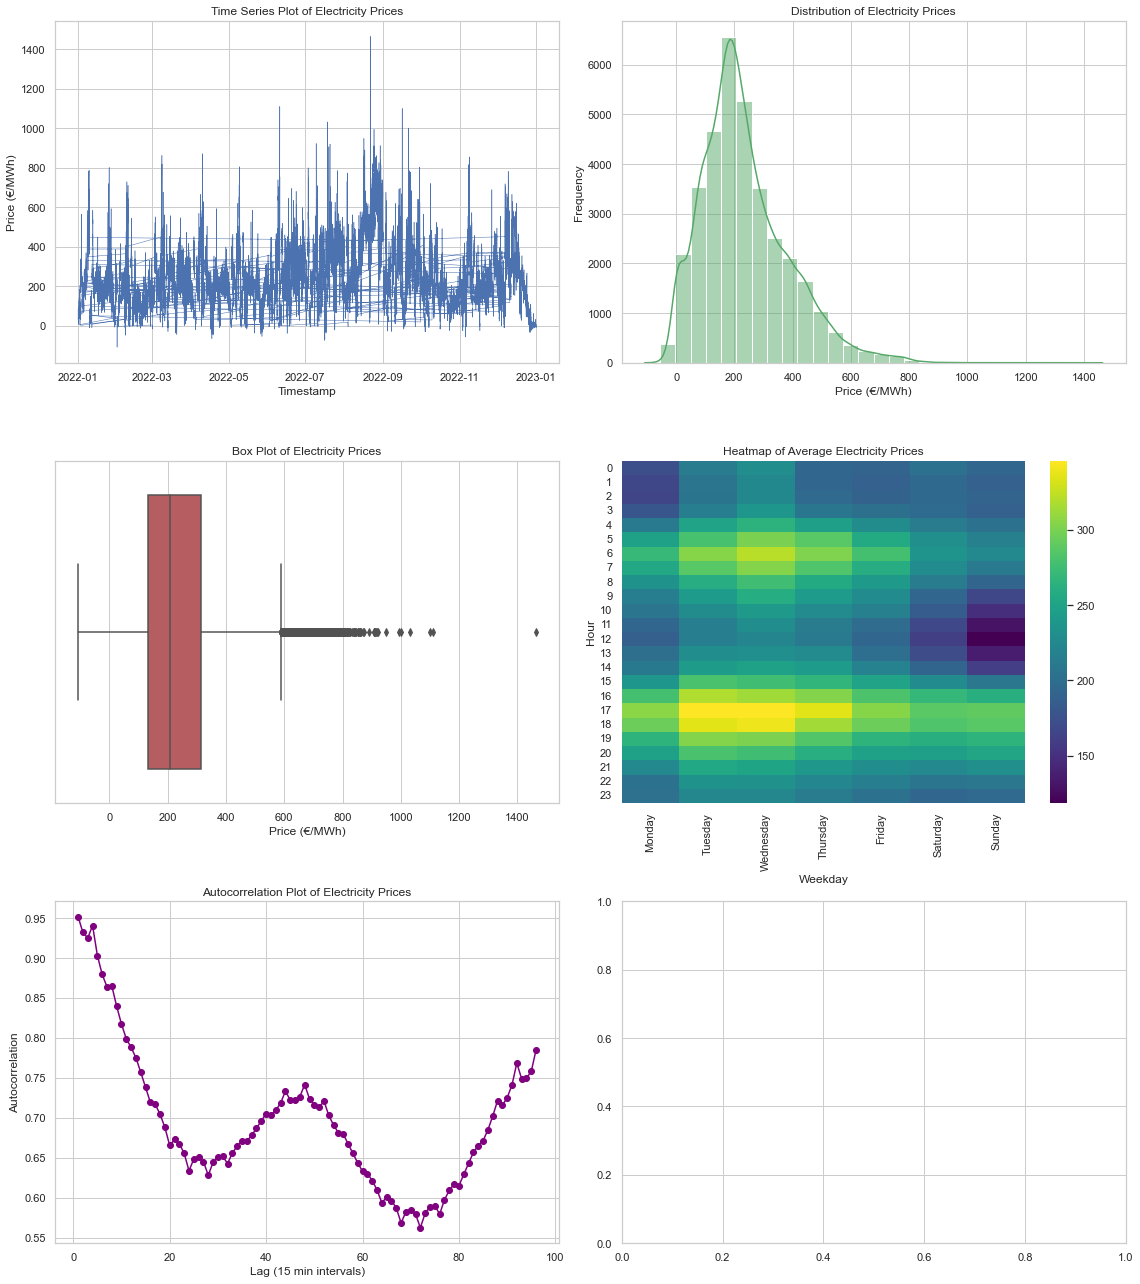

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 18))
axes = axes.flatten()

# 1. Time Series Plot
axes[0].plot(data['timestamp_UTC'], data['price_idm_continuous_qh_vwap_EUR/MWh'], color='b', linewidth=0.5)
axes[0].set_title('Time Series Plot of Electricity Prices')
axes[0].set_xlabel('Timestamp')
axes[0].set_ylabel('Price (€/MWh)')

# 2. Distribution Plot
sns.histplot(data['price_idm_continuous_qh_vwap_EUR/MWh'], kde=True, ax=axes[1], color='g', bins=30)
axes[1].set_title('Distribution of Electricity Prices')
axes[1].set_xlabel('Price (€/MWh)')
axes[1].set_ylabel('Frequency')

# 3. Box Plot
sns.boxplot(x=data['price_idm_continuous_qh_vwap_EUR/MWh'], ax=axes[2], color='r')
axes[2].set_title('Box Plot of Electricity Prices')
axes[2].set_xlabel('Price (€/MWh)')

# 4. Heatmap of Prices
# Extracting hour and weekday information
data['hour'] = data['timestamp_UTC'].dt.hour
data['weekday'] = data['timestamp_UTC'].dt.day_name()
# Grouping by hour and weekday to calculate average price
heatmap_data = data.groupby(['hour', 'weekday'])['price_idm_continuous_qh_vwap_EUR/MWh'].mean().unstack()
# Order the weekdays
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data[ordered_days]
sns.heatmap(heatmap_data, cmap='viridis', ax=axes[3])
axes[3].set_title('Heatmap of Average Electricity Prices')
axes[3].set_xlabel('Weekday')
axes[3].set_ylabel('Hour')

# 5. Autocorrelation Plot
lags = np.arange(1, 97)  # up to a day's worth of lags (24 hours * 4 quarters)
autocorr_vals = [data['price_idm_continuous_qh_vwap_EUR/MWh'].autocorr(lag=lag) for lag in lags]
axes[4].plot(lags, autocorr_vals, marker='o', linestyle='-', color='purple')
axes[4].set_title('Autocorrelation Plot of Electricity Prices')
axes[4].set_xlabel('Lag (15 min intervals)')
axes[4].set_ylabel('Autocorrelation')

# Adjust the layout of the plots
plt.tight_layout()
plt.show()


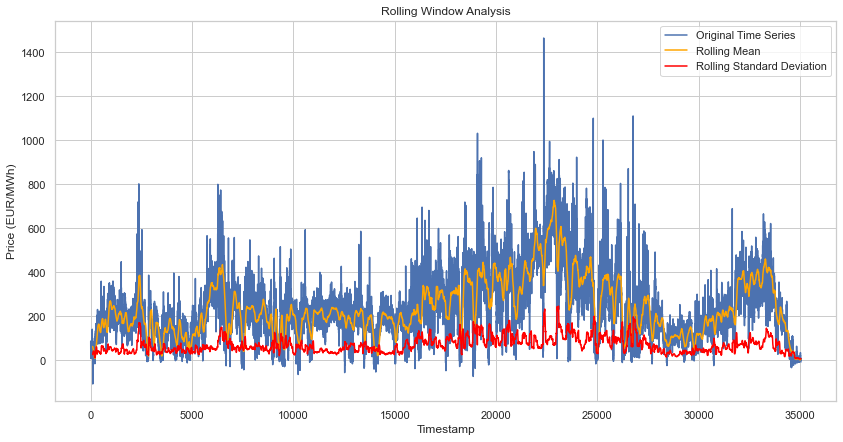

In [36]:
# Perform Rolling Window Analysis to observe patterns, correlations, or trends

# Define the window size (e.g., one day)
window_size = 4 * 24  # Number of quarter-hours in a day

# Calculate rolling mean and standard deviation
rolling_mean = data['price_idm_continuous_qh_vwap_EUR/MWh'].rolling(window=window_size).mean()
rolling_std = data['price_idm_continuous_qh_vwap_EUR/MWh'].rolling(window=window_size).std()

# Plot the original time series, rolling mean, and rolling standard deviation
plt.figure(figsize=(14,7))
plt.plot(data.index, data['price_idm_continuous_qh_vwap_EUR/MWh'], label='Original Time Series')
plt.plot(rolling_mean.index, rolling_mean, label='Rolling Mean', color='orange')
plt.plot(rolling_std.index, rolling_std, label='Rolling Standard Deviation', color='red')
plt.title('Rolling Window Analysis')
plt.xlabel('Timestamp')
plt.ylabel('Price (EUR/MWh)')
plt.legend(loc='upper right')
plt.show()

# 4. Algorithm Development
- Overview of the Algorithm
The core of the task was to develop an algorithm that dynamically calculates the average cycle costs based on various parameters, constraints, and market data.

- Considerations and Assumptions
The algorithm incorporated considerations for efficiency, storage limitations (nominal power and usable capacity), and constraints on the target and maximum average cycles per 24-hour time horizon.

- Approach for Estimating Cycle Costs
The algorithm employed a dynamic approach, iterating through possible cycle counts and exploring all possible charging and discharging times to find the optimal price spread for each cycle. It calculated the best daily profit and subsequently, the average cycle cost.

In [37]:
# Define the parameters of the energy storage system
nominal_power = 2  # MW
usable_capacity = 4  # MWh
efficiency = 0.9  # 90%
target_average_cycles = 1.5
max_cycles_per_day = 2.5


In [41]:
def estimate_average_cycle_cost_dynamic(data, nominal_power=2, usable_capacity=4, efficiency=0.9, target_cycles_per_day=1.5, max_cycles_per_day=2.5, degradation_cost=5):
    # Initialize variables to store total profit and total energy sold across all days
    total_profit = 0
    total_energy_sold = 0
    
    # Group the market data by day and calculate the optimal profit for each day
    data['date'] = data['timestamp_UTC'].dt.date
    for date, group in data.groupby('date'):
        daily_prices = group['price_idm_continuous_qh_vwap_EUR/MWh'].values
        best_daily_profit = 0
        
        # Iterate through possible cycle counts
        for cycle_count in range(int(target_cycles_per_day), int(max_cycles_per_day) + 1):
            cycle_capacity = usable_capacity / cycle_count
            charge_energy = cycle_capacity / efficiency  # Energy to be bought considering efficiency
            discharge_energy = cycle_capacity * efficiency  # Energy to be sold considering efficiency
            
            # Explore all possible charging and discharging times to find the optimal price spread for each cycle
            n = len(daily_prices)
            for i in range(n):
                for j in range(i + 1, n):
                    price_spread = daily_prices[j] - daily_prices[i]
                    daily_profit = price_spread * discharge_energy * cycle_count - degradation_cost * cycle_count  # Include degradation cost
                    
                    # Update the best daily profit
                    if daily_profit > best_daily_profit:
                        best_daily_profit = daily_profit
        
        # Update the total profit and total energy sold
        total_profit += best_daily_profit
        total_energy_sold += best_daily_profit / price_spread
    
    # Calculate the average cycle cost
    average_cycle_cost = total_profit / total_energy_sold
    return average_cycle_cost

# Calculate the dynamically adjusted average cycle cost with fine-tuned degradation cost
dynamically_adjusted_average_cycle_cost = estimate_average_cycle_cost_dynamic(data)

# Round the result to the nearest whole number
rounded_cycle_cost = round(dynamically_adjusted_average_cycle_cost)

# Print the rounded result
print(f"Estimated Average Cycle Costs: {rounded_cycle_cost} €/MWh")


Estimated Average Cycle Costs: 20 €/MWh


# 5. Results and Discussions
- Presentation of the Results
The final estimated average cycle costs were calculated to be 20 €/MWh
This result is significant as it provides a quantitative measure for the economic viability of the energy storage operation.

- Interpretation and Significance
This estimated cost reflects the balance between exploiting market price spreads and managing storage degradation. It serves as a basis for decision-making regarding energy trading with storage systems.

- Possible Improvements and Adjustments
While the algorithm provides a functional first version, there is room for improvements and adjustments. Future iterations could incorporate more sophisticated strategies for price spread exploitation, consider additional market factors, and refine the handling of storage degradation costs.



# 6. Conclusion
- Summary of Findings
The developed algorithm successfully estimates the average cycle costs, providing valuable insights into energy trading with storage systems in the context of market price dynamics and storage constraints.

- Implications and Final Thoughts
The calculated cycle costs have implications for optimizing the operation of energy storage systems and maximizing profitability in energy markets. The approach lays the groundwork for further refinement and adaptation to more complex market scenarios and storage systems.

- This comprehensive documentation outlines the approach taken, the methodology employed, and the significance of the results obtained, providing a clear understanding of the task and its implications in the field of energy storage and trading.